In [ ]:
import os
import json
import uuid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

import transformers
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    AutoConfig,
    get_linear_schedule_with_warmup
)
from transformers.modeling_outputs import SequenceClassifierOutput

from transformers.models.deberta_v2.configuration_deberta_v2 import DebertaV2Config
from transformers.models.deberta_v2.modeling_deberta_v2 import (
    DebertaV2PreTrainedModel,
    DebertaV2Model,
    ContextPooler
)

from datasets import load_dataset

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    precision_recall_curve
)

from tqdm import tqdm
from tqdm.auto import tqdm as auto_tqdm


# 1. Data Preprocess
In this part, we
*   Load train, dev and test data from hugging face and official google drive
https://drive.google.com/drive/folders/1Mz8vTnqi7truGrc05v6kWaod6mEK7Enj
*   Apply sampler for all three datasets to get smaller subsets, due to the limited computing resources
*   Save the sampled data to jsonl files for later usage
*   Map the testset's column names for later evaluation, as they originally differ from the train and development sets.

Alternatively, you can directly use our preprocessed data by simply download the dataset folder and running the code in the next optional session.





In [ ]:
# load train & val data from hugging face
ds = load_dataset("Jinyan1/COLING_2025_MGT_en")

# Extract train and dev sets, train 610767, dev 261758
train_set = ds['train']
dev_set = ds['dev']

print(len(train_set))
print(len(dev_set))
# Convert to pandas
train_df = train_set.to_pandas()
dev_df = dev_set.to_pandas()

data/train-00000-of-00002.parquet:   0%|          | 0.00/287M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/286M [00:00<?, ?B/s]

data/dev-00000-of-00001.parquet:   0%|          | 0.00/246M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/610767 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/261758 [00:00<?, ? examples/s]

610767
261758


In [ ]:
# Define the path to the test file
test_file_path = '/content/test_set_en_with_label.jsonl'

# Load the JSONL file into a pandas DataFrame
try:
    test_df = pd.read_json(test_file_path, lines=True)
except FileNotFoundError:
    print(f"Error: The file {test_file_path} was not found.")
except Exception as e:
    print(f"An error occurred while loading the file: {e}")

print(len(test_df)) #73941

73941


In [ ]:
def equal_stratified_sampler(df, column_name, target_count, random_seed = 42):
    unique_values = df[column_name].unique()
    num_unique_values = len(unique_values)
    samples_per_value = target_count // num_unique_values

    sampled_dfs = []
    for value in unique_values:
        value_df = df[df[column_name] == value]
        n_sample = min(samples_per_value, len(value_df))
        if n_sample > 0:
            sampled = value_df.sample(n=n_sample, random_state=random_seed)
            sampled_dfs.append(sampled)
            print(f"  Train - {value}: sampled {n_sample}/{len(value_df)}")
    sampled_df = pd.concat(sampled_dfs).sample(frac=1, random_state=random_seed).reset_index(drop=True)
    return sampled_df

# function for proportional stratified sampling by target column
def propotional_stratified_sampler(df, column_name, target_count, random_seed = 42):
    unique_values = df[column_name].unique()
    total_count = len(df)

    sampled_dfs = []
    for value in unique_values:
        value_df = df[df[column_name] == value]
        # Calculate proportional sample size based on class distribution
        proportion = len(value_df) / total_count
        n_sample = int(target_count * proportion)
        n_sample = min(n_sample, len(value_df))

        if n_sample > 0:
            sampled = value_df.sample(n=n_sample, random_state=random_seed)
            sampled_dfs.append(sampled)
            print(f"  {value}: sampled {n_sample}/{len(value_df)} (proportion: {proportion:.2%})")

    sampled_df = pd.concat(sampled_dfs).sample(frac=1, random_state=random_seed).reset_index(drop=True)
    return sampled_df

In [ ]:
# sample data
train_data = propotional_stratified_sampler(train_df, 'source', 20000)
val_data = propotional_stratified_sampler(dev_df, 'source', 6000)
test_data = propotional_stratified_sampler(test_df, 'source', 6000)

  Train - m4gt: sampled 8771/267863 (proportion: 43.86%)
  Train - mage: sampled 9335/285093 (proportion: 46.68%)
  Train - hc3: sampled 1893/57811 (proportion: 9.47%)
  Train - m4gt: sampled 2624/114487 (proportion: 43.74%)
  Train - mage: sampled 2807/122499 (proportion: 46.80%)
  Train - hc3: sampled 567/24772 (proportion: 9.46%)
  Train - CUDRT: sampled 1864/22978 (proportion: 31.08%)
  Train - ieltsduck: sampled 1798/22165 (proportion: 29.98%)
  Train - NLPeer-F1000: sampled 795/9798 (proportion: 13.25%)
  Train - peersum: sampled 979/12075 (proportion: 16.33%)
  Train - Mixset: sampled 282/3486 (proportion: 4.71%)
  Train - LLM-DetectAIve-IELTS: sampled 205/2535 (proportion: 3.43%)
  Train - NLPeer-ARR22: sampled 59/728 (proportion: 0.98%)
  Train - NLPeer-COLING20: sampled 14/176 (proportion: 0.24%)


In [ ]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

19999
5998
5996


In [ ]:
# save data for further usage
train_data.to_json('/content/sampled_train_data.jsonl', orient='records', lines=True)
val_data.to_json('/content/sampled_val_data.jsonl', orient='records', lines=True)
test_data.to_json('/content/sampled_test_data.jsonl', orient='records', lines=True)

In [ ]:
# preprocess sampled testset -- rename colomun, remove empty lines
test_path = "/content/sampled_test_data.jsonl"
output_path = "/content/sampled_test_data.jsonl"

rows = []
with open(test_path, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        try:
            rows.append(json.loads(line))
        except json.JSONDecodeError as e:
            print("[WARN] skip bad line:", e)

df = pd.DataFrame(rows)
print("Original columns:", df.columns.tolist())

# map：language -> lang, domain -> sub_source
if "language" in df.columns:
    df.rename(columns={"language": "lang"}, inplace=True)
if "domain" in df.columns:
    df.rename(columns={"domain": "sub_source"}, inplace=True)

# generate id
if "id" not in df.columns:
    if "testset_id" in df.columns:
        df["id"] = df["testset_id"].astype(str)
    else:
        df["id"] = [str(uuid.uuid4()) for _ in range(len(df))]

text_default = "nodomain"
str_cols = ["id", "source", "sub_source", "lang", "model", "text"]
for c in str_cols:
    if c not in df.columns:
        df[c] = text_default
    else:
        df[c] = df[c].fillna(text_default).astype(str)

#  "English"  ->  "en"
df["lang"] = df["lang"].str.strip().str.lower()
df["lang"] = df["lang"].replace({"english": "en"})

# label must be int
if "label" not in df.columns:
    raise ValueError("Missing label column in test set.")
df["label"] = pd.to_numeric(df["label"], errors="coerce")
df = df.dropna(subset=["label"])
df["label"] = df["label"].astype(int)

# keep the same col as val set
keep_cols = ["id", "source", "sub_source", "lang", "model", "label", "text"]
df_out = df[keep_cols]

print("Unified columns:", df_out.columns.tolist())
print("Example row:\n", df_out.iloc[0])

df_out.to_json(output_path, orient="records", lines=True, force_ascii=False)
print(f"Saved -> {output_path}, rows={len(df_out)}")

Original columns: ['text', 'language', 'label', 'source', 'model', 'prompt_flag', 'prompt', 'domain', 'paper_id', 'binary', 'mixset_category', 'testset_id']
Unified columns: ['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text']
Example row:
 id                                                        35754
source                                                    CUDRT
sub_source                                        Llama3_Expand
lang                                                         en
model                                                    Llama3
label                                                         1
text          Here is the expanded text:Let be an associativ...
Name: 0, dtype: object
Saved -> /content/sampled_test_data.jsonl, rows=5996


#(Optional) Load data directly if already exist

In [ ]:
# file path
train_file = '/content/sampled_train_data.jsonl'
val_file = '/content/sampled_val_data.jsonl'
test_file = '/content/sampled_test_data.jsonl'

In [ ]:
# load jsonl file
def load_jsonl(file_path):
    data_list = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line_num, line in enumerate(f, 1):
            try:
                data = json.loads(line.strip())
                # Check if 'label' key exists before appending
                if 'label' in data:
                    data_list.append(data)
                else:
                    print(f"Warning: Skipping item from line {line_num} in {file_path}: 'label' key missing.")
            except json.JSONDecodeError as e:
                print(f"Warning: Skipping malformed JSON line {line_num} in {file_path}: {line.strip()} - Error: {e}")
            except Exception as e:
                print(f"Warning: Skipping line {line_num} in {file_path} due to unexpected error: {e}")
    return data_list


train_data = load_jsonl(train_file)
val_data = load_jsonl(val_file)
test_data = load_jsonl(test_file)

print(f"=== Data Loaded ===")
print(f"Train samples: {len(train_data)}")
print(f"Val samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")
print(f"\nTrain - Label distribution:")
print(f"  Human (label=0): {sum(1 for d in train_data if d['label'] == 0)}")
print(f"  AI (label=1): {sum(1 for d in train_data if d['label'] == 1)}")
print(f"\nVal - Label distribution:")
print(f"  Human (label=0): {sum(1 for d in val_data if d['label'] == 0)}")
print(f"  AI (label=1): {sum(1 for d in val_data if d['label'] == 1)}")
print(f"\nTest - Label distribution:")
print(f"  Human (label=0): {sum(1 for d in test_data if d['label'] == 0)}")
print(f"  AI (label=1): {sum(1 for d in test_data if d['label'] == 1)}")

=== Data Loaded ===
Train samples: 19999
Val samples: 5998
Test samples: 5996

Train - Label distribution:
  Human (label=0): 7505
  AI (label=1): 12494

Val - Label distribution:
  Human (label=0): 2303
  AI (label=1): 3695

Test - Label distribution:
  Human (label=0): 2863
  AI (label=1): 3133


# 2. Calculate perplexity

In this part, we use the simplified version of calculating DNA-Detect LLM score(more details can be found in [paper](https://arxiv.org/pdf/2509.15550)).

For the LLM modelsWe use gpt2-medium and gpt2-large, also EleutherAI/pythia-160m and EleutherAI/pythia-410m.

Calulated scores are saved as json files for further usage and evaluation.

Part of the code in this section is adapted from [DNA-DetectLLM](https://github.com/Xiaoweizhu57/DNA-DetectLLM).




In [ ]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.0+cu126
CUDA: True
GPU: Tesla T4


In [ ]:
# calculate original & repaired perplexity
def sum_perplexity(encoding, logits):
    # encoding is the original input, use observer's tokenizer
    # logits is vocab_size's prob of each position in the text, generated by performer
    shifted_logits = logits[..., :-1, :]
    attention = encoding.attention_mask[..., 1:]
    labels_std = encoding.input_ids[..., 1:]  # token id of original text
    labels_max = torch.argmax(shifted_logits, dim=-1)  # token with max prob

    logits_T = shifted_logits.transpose(1, 2)

    ce_std = F.cross_entropy(logits_T, labels_std, reduction='none')
    ce_max = F.cross_entropy(logits_T, labels_max, reduction='none')

    attn_sum = attention.sum(dim=1).clamp(min=1)
    ppl_std = (ce_std * attention).sum(dim=1) / attn_sum #actual token vs. performer prediction -- how unatural performer think the text originally is
    ppl_max = (ce_max * attention).sum(dim=1) / attn_sum

    return (ppl_std + ppl_max).cpu().numpy()

# calculate cross entropy（observer vs. performer）
def entropy(p_logits, q_logits, encoding, pad_token_id):
    vocab_size = p_logits.shape[-1]
    total_tokens = q_logits.shape[-2]

    p_proba = F.softmax(p_logits, dim=-1).view(-1, vocab_size)
    q_scores = q_logits.view(-1, vocab_size)

    ce = F.cross_entropy(q_scores, p_proba, reduction='none').view(-1, total_tokens)
    padding_mask = (encoding.input_ids != pad_token_id).type(torch.uint8)

    agg_ce = ((ce * padding_mask).sum(1) / padding_mask.sum(1)).cpu().float().numpy()
    return agg_ce

In [ ]:
class SimpleDNADetectLLM:

    def __init__(self, observer_model_name="gpt2-medium", performer_model_name="gpt2-xl"):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        print(f"load Observer: {observer_model_name}...")
        self.observer_model = AutoModelForCausalLM.from_pretrained(observer_model_name).to(self.device)
        self.observer_model.eval()

        print(f"load Performer: {performer_model_name}...")
        self.performer_model = AutoModelForCausalLM.from_pretrained(performer_model_name).to(self.device)
        self.performer_model.eval()

        self.tokenizer = AutoTokenizer.from_pretrained(observer_model_name)
        if not self.tokenizer.pad_token:
            self.tokenizer.pad_token = self.tokenizer.eos_token


    def compute_score(self, text):
        # Tokenize
        encoding = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=512,
            return_token_type_ids=False
        ).to(self.device)


        with torch.no_grad():
            observer_logits = self.observer_model(**encoding).logits
            performer_logits = self.performer_model(**encoding).logits


        ppl = sum_perplexity(encoding, performer_logits)
        x_ppl = entropy(observer_logits, performer_logits, encoding, self.tokenizer.pad_token_id)


        score = ppl / (2 * x_ppl)

        return score[0] if isinstance(score, np.ndarray) else score


In [ ]:
# optional - another detector
detector = SimpleDNADetectLLM(
    observer_model_name="EleutherAI/pythia-160m",  # 160M
    performer_model_name="EleutherAI/pythia-410m"      # 410M
)

load Observer: EleutherAI/pythia-160m...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

load Performer: EleutherAI/pythia-410m...


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/911M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

In [ ]:
# calculate perplexity score
def compute_and_save_scores(data_list, output_file, detector):

    # if exists, load directly
    if os.path.exists(output_file):
        print(f"Loading existing scores from {output_file}")
        with open(output_file, 'r') as f:
            scores = json.load(f)
        return scores

    # otherwise calculate
    print(f"Computing scores for {len(data_list)} samples...")
    scores = []
    for item in tqdm(data_list, desc="DNA-DETECT"):
      score = detector.compute_score(item['text'])
      scores.append(float(score))

    # save
    with open(output_file, 'w') as f:
        json.dump(scores, f)
    print(f"Scores saved to {output_file}")

    return scores

In [ ]:
train_scores = compute_and_save_scores(train_data, '/content/train_dna_scores.json', detector)
val_scores = compute_and_save_scores(val_data, '/content/val_dna_scores.json', detector)
test_scores = compute_and_save_scores(test_data, '/content/test_dna_scores.json', detector)

print(f"\n=== Perplexity Statistics ===")
print(f"Train - Mean: {np.mean(train_scores):.4f}, Std: {np.std(train_scores):.4f}")
print(f"Val - Mean: {np.mean(val_scores):.4f}, Std: {np.std(val_scores):.4f}")
print(f"Test - Mean: {np.mean(test_scores):.4f}, Std: {np.std(test_scores):.4f}")

Loading existing scores from /content/train_dna_scores.json
Loading existing scores from /content/val_dna_scores.json
Loading existing scores from /content/test_dna_scores.json

=== Perplexity Statistics ===
Train - Mean: 0.5527, Std: 0.0633
Val - Mean: 0.5542, Std: 0.0638
Test - Mean: 0.5749, Std: 0.0590


In [ ]:
# normalize for later train
# use mean and std of the train set
scaler = StandardScaler()
train_scores_array = np.array(train_scores).reshape(-1, 1)
val_scores_array = np.array(val_scores).reshape(-1, 1)
test_scores_array = np.array(test_scores).reshape(-1, 1)


# fit and transform
train_scores_normalized = scaler.fit_transform(train_scores_array).flatten()
val_scores_normalized = scaler.transform(val_scores_array).flatten()
test_scores_normalized = scaler.transform(test_scores_array).flatten()


print(f"\n=== Normalized Perplexity ===")
print(f"Train - Mean: {train_scores_normalized.mean():.4f}, Std: {train_scores_normalized.std():.4f}")
print(f"Val - Mean: {val_scores_normalized.mean():.4f}, Std: {val_scores_normalized.std():.4f}")
print(f"Test - Mean: {test_scores_normalized.mean():.4f}, Std: {test_scores_normalized.std():.4f}")


=== Normalized Perplexity ===
Train - Mean: 0.0000, Std: 1.0000
Val - Mean: 0.0244, Std: 1.0090
Test - Mean: 0.3511, Std: 0.9327


# (Optional) Load score directly if exist, then normalize (repeated code as above)

In [ ]:
# load score directly
def read_existed_scores(output_file):
  if os.path.exists(output_file):
      print(f"Loading existing scores from {output_file}")
      with open(output_file, 'r') as f:
          scores = json.load(f)
      return scores

In [ ]:
train_scores = read_existed_scores ('/content/train_dna_scores.json')
val_scores = read_existed_scores('/content/val_dna_scores.json')
test_scores = read_existed_scores('/content/test_dna_scores.json')

Loading existing scores from /content/train_dna_scores.json
Loading existing scores from /content/val_dna_scores.json
Loading existing scores from /content/test_dna_scores.json


In [ ]:
# normalize for later train
# use mean and std of the train set
scaler = StandardScaler()
train_scores_array = np.array(train_scores).reshape(-1, 1)
val_scores_array = np.array(val_scores).reshape(-1, 1)
test_scores_array = np.array(test_scores).reshape(-1, 1)


# fit and transform
train_scores_normalized = scaler.fit_transform(train_scores_array).flatten()
val_scores_normalized = scaler.transform(val_scores_array).flatten()
test_scores_normalized = scaler.transform(test_scores_array).flatten()


print(f"\n=== Normalized Perplexity ===")
print(f"Train - Mean: {train_scores_normalized.mean():.4f}, Std: {train_scores_normalized.std():.4f}")
print(f"Val - Mean: {val_scores_normalized.mean():.4f}, Std: {val_scores_normalized.std():.4f}")
print(f"Test - Mean: {test_scores_normalized.mean():.4f}, Std: {test_scores_normalized.std():.4f}")


=== Normalized Perplexity ===
Train - Mean: 0.0000, Std: 1.0000
Val - Mean: 0.0128, Std: 1.0023
Test - Mean: 0.2451, Std: 0.7519


# 3. Model Config
In this part we define the new model and dataset, where we add perplexity as an additional input to DebertaV2, and load the weight from a pretrained model (deberta-v3-base-daigenc-mgt1a, more details can be found in [Paper](https://aclanthology.org/2025.genaidetect-1.26.pdf)).

Part of the code in this section is adapted from [GitHub](https://github.com/Advacheck-OU/ai-detector-coling2025/tree/main)


In [ ]:
# Define dataset
class MGTDatasetWithPerplexity(Dataset):
    """include perplexity as input"""
    def __init__(self, data_list, perplexity_scores, tokenizer, max_length=512):
        self.data_list = data_list
        self.perplexity_scores = perplexity_scores
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        item = self.data_list[idx]

        # Tokenize text
        encoding = self.tokenizer(
            item['text'],
            max_length=self.max_length,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'perplexity_feature': torch.tensor([self.perplexity_scores[idx]], dtype=torch.float32),
            'labels': torch.tensor(item['label'], dtype=torch.long),
            'source': item['source'],
            'sub_source': item['sub_source'],
            'model': item['model']
        }

In [ ]:
# load pretrained model and transfer the weight
from transformers import AutoTokenizer, AutoConfig

pretrained_model_name = "OU-Advacheck/deberta-v3-base-daigenc-mgt1a"
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
base_config = AutoConfig.from_pretrained(pretrained_model_name)

print(f"Loaded tokenizer and config from {pretrained_model_name}")

# load the base model for training later
from transformers import DebertaV2ForSequenceClassification
pretrained_model = DebertaV2ForSequenceClassification.from_pretrained(pretrained_model_name)

print("Loaded pretrained model for weight transfer")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/952 [00:00<?, ?B/s]

Loaded tokenizer and config from OU-Advacheck/deberta-v3-base-daigenc-mgt1a


model.safetensors:   0%|          | 0.00/740M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at OU-Advacheck/deberta-v3-base-daigenc-mgt1a and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded pretrained model for weight transfer


In [ ]:
# define the new DeBERTa model
import torch
from torch import nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

import transformers
from transformers import models
from transformers.modeling_outputs import SequenceClassifierOutput

from transformers.models.deberta_v2.configuration_deberta_v2 import DebertaV2Config
from transformers.models.deberta_v2.modeling_deberta_v2 import (
    DebertaV2PreTrainedModel,
    DebertaV2Model,
    ContextPooler
)


class DebertaV2WithPerplexity(DebertaV2PreTrainedModel):
    """DeBERTa + Perplexity"""

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = 2  # binary classification
        self.config = config

        # DeBERTa core
        self.deberta = DebertaV2Model(config)

        drop_out = getattr(config, "cls_dropout", None)
        drop_out = config.hidden_dropout_prob if drop_out is None else drop_out
        self.dropout = nn.Dropout(drop_out)

        self.pooler = ContextPooler(config)

        # Classification head：input = hidden_size + 1 (perplexity)
        H1, H2 = 512, 256
        self.classifier = nn.Sequential(
            nn.Linear(config.hidden_size + 1, H1),  # 768+1 → 512
            nn.GELU(),
            nn.Linear(H1, H2),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(H2, self.num_labels)
        )

        self.post_init()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        perplexity_feature=None,  # newly added param
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # DeBERTa
        outputs = self.deberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        encoder_layer = outputs[0]
        pooled_output = self.pooler(encoder_layer)
        pooled_output = self.dropout(pooled_output)

        # map perplexity
        if perplexity_feature is not None:
            # perplexity_feature: [batch_size, 1]
            pooled_output = torch.cat([pooled_output, perplexity_feature], dim=-1)  # [B, 769]
        else:
            # if not offered, filled with 0
            batch_size = pooled_output.size(0)
            zero_feature = torch.zeros(batch_size, 1, device=pooled_output.device)
            pooled_output = torch.cat([pooled_output, zero_feature], dim=-1)

        logits = self.classifier(pooled_output)

        # calculate loss
        loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


In [ ]:
# create new model
new_model = DebertaV2WithPerplexity(base_config)

# load weight
new_model.deberta.load_state_dict(pretrained_model.deberta.state_dict())
new_model.pooler.load_state_dict(pretrained_model.pooler.state_dict())
print("Transferred DeBERTa and pooler weights")

old_classifier_weight = pretrained_model.classifier.weight.data  # [2, 768]
old_classifier_bias = pretrained_model.classifier.bias.data      # [2]

# initialize classification head, set weight of perplexity as 0, others use the old weight
with torch.no_grad():
    # first layer: Linear(769, 512)
    first_layer = new_model.classifier[0]  # Linear(769, 512)
    nn.init.xavier_uniform_(first_layer.weight[:, :768])
    first_layer.weight[:, 768] = 0.0
    nn.init.zeros_(first_layer.bias)

print("Initialized new classifier head (perplexity weights = 0)")
print(f"Model ready for training. Total parameters: {sum(p.numel() for p in new_model.parameters()):,}")

Transferred DeBERTa and pooler weights
Initialized new classifier head (perplexity weights = 0)
Model ready for training. Total parameters: 184,948,226


# 4. Baseline
We use 2 baselines here
*   Perplexity + threshold
*   Pretrained model






## Baseline 1 Perplexity + Threshold

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

def evaluate_perplexity_baseline(scores, labels, thresholds=None):
    """use perplexity score and threshold as classifier"""
    scores = np.array(scores)
    labels = np.array(labels)

    if thresholds is None:
        # find the best threshold on train set
        best_threshold = None
        best_f1 = 0

        # try different threshold
        for percentile in range(10, 100, 5):
            threshold = np.percentile(scores, percentile)
            preds = (scores < threshold).astype(int) #human label = 0
            f1 = f1_score(labels, preds)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold

        thresholds = [best_threshold]
        print(f"  Best threshold from training: {best_threshold:.4f} (F1={best_f1:.4f})")

    results = []
    for threshold in thresholds:
        preds = (scores < threshold).astype(int) #human label=0
        results.append({
            'threshold': threshold,
            'accuracy': accuracy_score(labels, preds),
            'precision': precision_score(labels, preds, zero_division=0),
            'recall': recall_score(labels, preds, zero_division=0),
            'f1': f1_score(labels, preds, zero_division=0),
        })

    return results

In [ ]:
print("=== Baseline 1: Perplexity Only ===")
print("\nFinding optimal threshold on train set...")
train_labels = [d['label'] for d in train_data]
train_results = evaluate_perplexity_baseline(train_scores, train_labels)
optimal_threshold = train_results[0]['threshold']
print(f"train results:{train_results}")

print(f"\nEvaluating on validation set with threshold={optimal_threshold:.4f}...")
val_labels = [d['label'] for d in val_data]
val_results = evaluate_perplexity_baseline(val_scores, val_labels, thresholds=[optimal_threshold])

print(f"\nValidation Results:")
print(f"  Accuracy:  {val_results[0]['accuracy']:.4f}")
print(f"  Precision: {val_results[0]['precision']:.4f}")
print(f"  Recall:    {val_results[0]['recall']:.4f}")
print(f"  F1-Score:  {val_results[0]['f1']:.4f}")

=== Baseline 1: Perplexity Only ===

Finding optimal threshold on train set...
  Best threshold from training: 0.5908 (F1=0.7548)
train results:[{'threshold': np.float64(0.5908156752586364), 'accuracy': 0.6139306965348268, 'precision': 0.6256118743091742, 'recall': 0.9513366415879623, 'f1': 0.7548344076461436}]

Evaluating on validation set with threshold=0.5908...

Validation Results:
  Accuracy:  0.6020
  Precision: 0.6153
  Recall:    0.9448
  F1-Score:  0.7452


In [ ]:
print(f"\nEvaluating on Test set with threshold={optimal_threshold:.4f}...")
test_labels = [d['label'] for d in test_data]
test_results = evaluate_perplexity_baseline(test_scores, test_labels, thresholds=[optimal_threshold])

print(f"\nTest Results:")
print(f"  Accuracy:  {test_results[0]['accuracy']:.4f}")
print(f"  Precision: {test_results[0]['precision']:.4f}")
print(f"  Recall:    {test_results[0]['recall']:.4f}")
print(f"  F1-Score:  {test_results[0]['f1']:.4f}")


Evaluating on Test set with threshold=0.5908...

Test Results:
  Accuracy:  0.5572
  Precision: 0.5415
  Recall:    0.9952
  F1-Score:  0.7014


###  Evaluate by sub-source (on validation set)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

def evaluate_by_group(data_list, labels, preds, probs=None, group_key="sub_source", model_name=None):
    """
    data_list: list[dict],sub_source/source/model
    group_key: 'sub_source'/'source'/'domain'/...
    model_name: baseline 1,baselin2
    """
    labels = np.array(labels)
    preds = np.array(preds)
    probs = None if probs is None else np.array(probs)

    assert len(data_list) == len(labels) == len(preds), "incosisdent length of data_list/labels/preds"
    if probs is not None:
        assert len(probs) == len(labels),  "incosisdent length of probs"

    # group value（fill with 'UNKNOWN' in case of missing）
    groups = [d.get(group_key, "UNKNOWN") for d in data_list]

    rows = []
    for g in sorted(set(groups)):
        idxs = np.where(np.array(groups) == g)[0]
        y = labels[idxs]
        p = preds[idxs]

        row = {
            "model": model_name,
            group_key: g,
            "count": int(len(idxs)),
            "accuracy": float(accuracy_score(y, p)),
            "precision": float(precision_score(y, p, zero_division=0)),
            "recall": float(recall_score(y, p, zero_division=0)),
            "f1": float(f1_score(y, p, zero_division=0)),
        }


        if probs is not None and len(np.unique(y)) > 1:
            row["auc"] = float(roc_auc_score(y, probs[idxs]))
        else:
            row["auc"] = None

        rows.append(row)

    df = pd.DataFrame(rows).sort_values(["count"], ascending=False).reset_index(drop=True)
    return df

In [ ]:
baseline1_labels = [d["label"] for d in val_data]
baseline1_preds = (np.array(val_scores) < optimal_threshold).astype(int)

baseline1_sub_df = evaluate_by_group(
    data_list=val_data,
    labels=baseline1_labels,
    preds=baseline1_preds,
    probs=None,
    group_key="sub_source",
    model_name="baseline1"
)
display(baseline1_sub_df)

,model,sub_source,count,accuracy,precision,recall,f1,auc
0,baseline1,wikihow,565,0.612389,0.612100,0.997101,0.758545,None
1,baseline1,arxiv,525,0.552381,0.554493,0.993151,0.711656,None
2,baseline1,reddit,483,0.608696,0.609959,0.996610,0.756757,None
3,baseline1,wikipedia,473,0.553911,0.553911,1.000000,0.712925,None
4,baseline1,reddit_eli5,448,0.363839,0.263566,1.000000,0.417178,None
5,baseline1,outfox,410,0.946341,0.950860,0.994859,0.972362,None
6,baseline1,yelp,407,0.398034,0.381868,0.874214,0.531549,None
7,baseline1,eli5,352,0.573864,0.611111,0.891892,0.725275,None
8,baseline1,xsum,305,0.747541,0.775510,0.953975,0.855535,None
9,baseline1,squad,300,0.423333,0.439446,0.920290,0.594848,None


In [ ]:
# save as json
with open("baseline1_by_sub_source.json", "w") as f:
    json.dump(baseline1_sub_df.to_dict("records"), f, indent=2)

### Evaluate by sub-source (test set)

In [ ]:
baseline1_labels = [d["label"] for d in test_data]
baseline1_preds = (np.array(test_scores) < optimal_threshold).astype(int)
baseline1_sub_test_df = evaluate_by_group(
    data_list=test_data,
    labels=baseline1_labels,
    preds=baseline1_preds,
    probs=None,
    group_key="sub_source",
    model_name="baseline1_test"
)
display(baseline1_sub_test_df)

,model,sub_source,count,accuracy,precision,recall,f1,auc
0,baseline1_test,ielts,1682,0.583829,0.556401,1.000000,0.714984,None
1,baseline1_test,nodomain,979,0.601634,0.579741,1.000000,0.733970,None
2,baseline1_test,Academic peer review,868,0.524194,0.513545,1.000000,0.678599,None
3,baseline1_test,GPT3.5_Refine,434,0.057604,0.057604,1.000000,0.108932,None
4,baseline1_test,GPT3.5_QA,408,0.125000,0.070312,1.000000,0.131387,None
5,baseline1_test,GPT3.5_Summary,240,0.133333,0.106667,0.774194,0.187500,None
6,baseline1_test,IELTS Essay,205,0.395122,0.342246,0.984615,0.507937,None
7,baseline1_test,IELTS,116,1.000000,1.000000,1.000000,1.000000,None
8,baseline1_test,game_review,41,1.000000,1.000000,1.000000,1.000000,None
9,baseline1_test,TruthfulQA_LLMs,38,0.473684,0.473684,1.000000,0.642857,None


In [ ]:
with open("baseline1_by_sub_source_test.json", "w") as f:
    json.dump(baseline1_sub_test_df.to_dict("records"), f, indent=2)

## Baseline 2: Pretrained model（without perplexity）

In [ ]:
def evaluate_deberta_baseline(model, data_list, tokenizer, batch_size=32, threshold=0.4):

    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for i in tqdm(range(0, len(data_list), batch_size), desc="DeBERTa Baseline"):
            batch = data_list[i:i+batch_size]
            texts = [item['text'] for item in batch]
            labels = [item['label'] for item in batch]

            # Tokenize
            inputs = tokenizer(
                texts,
                max_length=512,
                truncation=True,
                padding='max_length',
                return_tensors='pt'
            ).to(device)

            # Forward
            outputs = model(**inputs)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)[:, 0].cpu().numpy()  # P(AI)

            # Threshold-based prediction
            preds = (probs > threshold).astype(int)

            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels)

    # Calculate metrics
    results = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds, zero_division=0),
        'recall': recall_score(all_labels, all_preds, zero_division=0),
        'f1': f1_score(all_labels, all_preds, zero_division=0),
        'auc': roc_auc_score(all_labels, all_probs) if len(set(all_labels)) > 1 else 0.0
    }

    return results, all_preds, all_probs


In [ ]:
print("=== Baseline 2: Pretrained DeBERTa (No Perplexity) ===")
print("Evaluating on validation set...")
deberta_results, deberta_preds, deberta_probs = evaluate_deberta_baseline(
    pretrained_model,
    val_data,
    tokenizer,
    threshold=0.3  #selected based on the best f1 of val set
)

print(f"\n Validation Results (threshold={0.3:.2f}):")
print(f"  Accuracy:  {deberta_results['accuracy']:.4f}")
print(f"  Precision: {deberta_results['precision']:.4f}")
print(f"  Recall:    {deberta_results['recall']:.4f}")
print(f"  F1-Score:  {deberta_results['f1']:.4f}")
print(f"  AUC:       {deberta_results['auc']:.4f}")

=== Baseline 2: Pretrained DeBERTa (No Perplexity) ===
Evaluating on validation set...


DeBERTa Baseline: 100%|██████████| 188/188 [04:46<00:00,  1.52s/it]


 Validation Results (threshold=0.30):
  Accuracy:  0.5972
  Precision: 0.6430
  Recall:    0.7781
  F1-Score:  0.7041
  AUC:       0.6223


In [ ]:
print("Evaluating on test set...")
deberta_test_results, deberta_test_preds, deberta_test_probs = evaluate_deberta_baseline(
    pretrained_model,
    test_data,
    tokenizer,
    threshold=0.3 #selected based on the best f1 perf on validation set
)

print(f"\nTest Results (threshold={0.3:.2f}):") # Corrected threshold display
print(f"  Accuracy:  {deberta_test_results['accuracy']:.4f}")
print(f"  Precision: {deberta_test_results['precision']:.4f}")
print(f"  Recall:    {deberta_test_results['recall']:.4f}")
print(f"  F1-Score:  {deberta_test_results['f1']:.4f}")
print(f"  AUC:       {deberta_test_results['auc']:.4f}")

Evaluating on test set...


DeBERTa Baseline: 100%|██████████| 188/188 [04:59<00:00,  1.59s/it]


Test Results (threshold=0.30):
  Accuracy:  0.5370
  Precision: 0.5311
  Recall:    0.9716
  F1-Score:  0.6868
  AUC:       0.5934


### Evaluate by sub-source (on validation set)

In [ ]:
deberta_labels = [d["label"] for d in val_data]

deberta_sub_df = evaluate_by_group(
    data_list=val_data,
    labels=deberta_labels,
    preds=deberta_preds,
    probs=deberta_probs,
    group_key="sub_source",
    model_name="baseline2"
)

display(deberta_sub_df)

,model,sub_source,count,accuracy,precision,recall,f1,auc
0,baseline2,wikihow,565,0.407080,0.916667,0.031884,0.061625,0.620422
1,baseline2,arxiv,525,0.556190,0.556190,1.000000,0.714810,0.011905
2,baseline2,reddit,483,0.685300,0.660674,0.996610,0.794595,0.994284
3,baseline2,wikipedia,473,0.156448,0.215768,0.198473,0.206759,0.111772
4,baseline2,reddit_eli5,448,0.988839,0.961905,0.990196,0.975845,0.990423
5,baseline2,outfox,410,0.507317,0.989529,0.485861,0.651724,0.830701
6,baseline2,yelp,407,0.390663,0.390663,1.000000,0.561837,0.844035
7,baseline2,eli5,352,0.792614,0.754266,0.995495,0.858252,0.942412
8,baseline2,xsum,305,0.783607,0.783607,1.000000,0.878676,0.797705
9,baseline2,squad,300,0.443333,0.450847,0.963768,0.614319,0.654410


In [ ]:
with open("baseline2_by_sub_source.json", "w") as f:
    json.dump(deberta_sub_df.to_dict("records"), f, indent=2)

### Evaluate by sub-source (on test set)

In [ ]:
deberta_labels = [d["label"] for d in test_data]
deberta_sub_df_test = evaluate_by_group(
    data_list=test_data,
    labels=deberta_labels,
    preds=deberta_test_preds,
    probs=deberta_test_probs,
    group_key="sub_source",
    model_name="baseline2_test"
)

display(deberta_sub_df_test)

,model,sub_source,count,accuracy,precision,recall,f1,auc
0,baseline2_test,ielts,1682,0.530321,0.527534,0.960137,0.680937,0.531296
1,baseline2_test,nodomain,979,0.549540,0.549540,1.000000,0.709295,0.998795
2,baseline2_test,Academic peer review,868,0.502304,0.502304,1.000000,0.668712,0.998572
3,baseline2_test,GPT3.5_Refine,434,0.059908,0.057737,1.000000,0.109170,0.511589
4,baseline2_test,GPT3.5_QA,408,0.328431,0.054152,0.555556,0.098684,0.447847
5,baseline2_test,GPT3.5_Summary,240,0.129167,0.129167,1.000000,0.228782,0.319339
6,baseline2_test,IELTS Essay,205,0.351220,0.328283,1.000000,0.494297,0.554505
7,baseline2_test,IELTS,116,1.000000,1.000000,1.000000,1.000000,NaN
8,baseline2_test,game_review,41,1.000000,1.000000,1.000000,1.000000,NaN
9,baseline2_test,TruthfulQA_LLMs,38,0.447368,0.459459,0.944444,0.618182,0.927778


In [ ]:
with open("baseline2_by_sub_source_test.json", "w") as f:
    json.dump(deberta_sub_df_test.to_dict("records"), f, indent=2)

### Debug & Search best threshold

---



In [ ]:
# Check model label mapping
print("=== Checking Model Configuration ===")
print(f"Model config - id2label: {pretrained_model.config.id2label}")
print(f"Model config - label2id: {pretrained_model.config.label2id}")

# Check a few predictions
sample_texts = [train_data[0]['text'], train_data[1]['text'],  train_data[2]['text'], train_data[3]['text'], train_data[4]['text'], train_data[5]['text']]
sample_labels = [train_data[0]['label'], train_data[1]['label'], train_data[2]['label'], train_data[3]['label'], train_data[4]['label'], train_data[5]['label']]

inputs = tokenizer(sample_texts, max_length=512, truncation=True, padding='max_length', return_tensors='pt')
if torch.cuda.is_available():
    inputs = inputs.to('cuda')
    pretrained_model.to('cuda')

with torch.no_grad():
    outputs = pretrained_model(**inputs)
    logits = outputs.logits
    probs = torch.softmax(logits, dim=1).cpu().numpy()

print("\nSample predictions:")
for i in range(len(sample_texts)):
    print(f"\nSample {i+1}:")
    print(f"  True label: {sample_labels[i]} ({'Human' if sample_labels[i]==0 else 'AI'})")
    print(f"  Probs [Human, AI]: [{probs[i][0]:.4f}, {probs[i][1]:.4f}]")
    print(f"  Predicted: {np.argmax(probs[i])} ({'Human' if np.argmax(probs[i])==0 else 'AI'})")

=== Checking Model Configuration ===
Model config - id2label: {0: 'LABEL_0', 1: 'LABEL_1'}
Model config - label2id: {'LABEL_0': 0, 'LABEL_1': 1}

Sample predictions:

Sample 1:
  True label: 1 (AI)
  Probs [Human, AI]: [0.4636, 0.5364]
  Predicted: 1 (AI)

Sample 2:
  True label: 0 (Human)
  Probs [Human, AI]: [0.2914, 0.7086]
  Predicted: 1 (AI)

Sample 3:
  True label: 1 (AI)
  Probs [Human, AI]: [0.2450, 0.7550]
  Predicted: 1 (AI)

Sample 4:
  True label: 1 (AI)
  Probs [Human, AI]: [0.2584, 0.7416]
  Predicted: 1 (AI)

Sample 5:
  True label: 1 (AI)
  Probs [Human, AI]: [0.4745, 0.5255]
  Predicted: 1 (AI)

Sample 6:
  True label: 1 (AI)
  Probs [Human, AI]: [0.4671, 0.5329]
  Predicted: 1 (AI)


In [ ]:
# debug
print(f"\n=== Probability Distribution ===")
print(f"  Min:  {np.min(deberta_probs):.4f}")
print(f"  Max:  {np.max(deberta_probs):.4f}")
print(f"  Mean: {np.mean(deberta_probs):.4f}")
print(f"  Std:  {np.std(deberta_probs):.4f}")
print(f"  Median: {np.median(deberta_probs):.4f}")
print(f"\nPercentiles:")
for p in [10, 25, 50, 75, 90, 95, 99]:
    print(f"  {p}th: {np.percentile(deberta_probs, p):.4f}")

# debug
print(f"\n=== Prediction Analysis (threshold={0.3:.2f}) ===") # Corrected threshold display
print(f"  Predicted as Human (0): {np.sum(np.array(deberta_preds) == 0)} ({np.sum(np.array(deberta_preds) == 0)/len(deberta_preds)*100:.1f}%)") # Cast to np array
print(f"  Predicted as AI (1):    {np.sum(np.array(deberta_preds) == 1)} ({np.sum(np.array(deberta_preds) == 1)/len(deberta_preds)*100:.1f}%)") # Cast to np array
print(f"\n  Actual Human (0): {np.sum(np.array([d['label'] for d in test_data]) == 0)}")
print(f"  Actual AI (1):    {np.sum(np.array([d['label'] for d in test_data]) == 1)}")

print(f"\nTest Results (threshold={0.3:.2f}):") # Corrected threshold display
print(f"  Accuracy:  {deberta_results['accuracy']:.4f}")
print(f"  Precision: {deberta_results['precision']:.4f}")
print(f"  Recall:    {deberta_results['recall']:.4f}")
print(f"  F1-Score:  {deberta_results['f1']:.4f}")
print(f"  AUC:       {deberta_results['auc']:.4f}")


=== Probability Distribution ===
  Min:  0.0766
  Max:  0.7080
  Mean: 0.3847
  Std:  0.1268
  Median: 0.4209

Percentiles:
  10th: 0.2003
  25th: 0.2981
  50th: 0.4209
  75th: 0.4574
  90th: 0.5136
  95th: 0.5830
  99th: 0.6988

=== Prediction Analysis (threshold=0.30) ===
  Predicted as Human (0): 1527 (25.5%)
  Predicted as AI (1):    4471 (74.5%)

  Actual Human (0): 2863
  Actual AI (1):    3133

Test Results (threshold=0.30):
  Accuracy:  0.5972
  Precision: 0.6430
  Recall:    0.7781
  F1-Score:  0.7041
  AUC:       0.6223


=== DeBERTa Baseline: Threshold Sensitivity Analysis ===

1. Testing Different Thresholds:
Threshold    Accuracy   Precision   Recall    F1-Score   AUC        Strategy            
-----------------------------------------------------------------------------------------------
0.3000       0.5972     0.6430      0.7781    0.7041     0.6223     Low (0.3)           
0.4000       0.6509     0.7355      0.6766    0.7048     0.6223     Medium-Low (0.4)    
0.5000       0.3898     0.5249      0.0999    0.1678     0.6223     Default (0.5)       
0.6000       0.4055     0.8274      0.0441    0.0838     0.6223     Medium (0.6)        
0.7000       0.3920     1.0000      0.0130    0.0256     0.6223     Medium-High (0.7)   
0.8000       0.3840     0.0000      0.0000    0.0000     0.6223     High (0.8)          
0.9200       0.3840     0.0000      0.0000    0.0000     0.6223     Paper default (0.92)
0.4209       0.6459     0.7619      0.6184    0.6827     0.6223     Median prob         
0.3847      

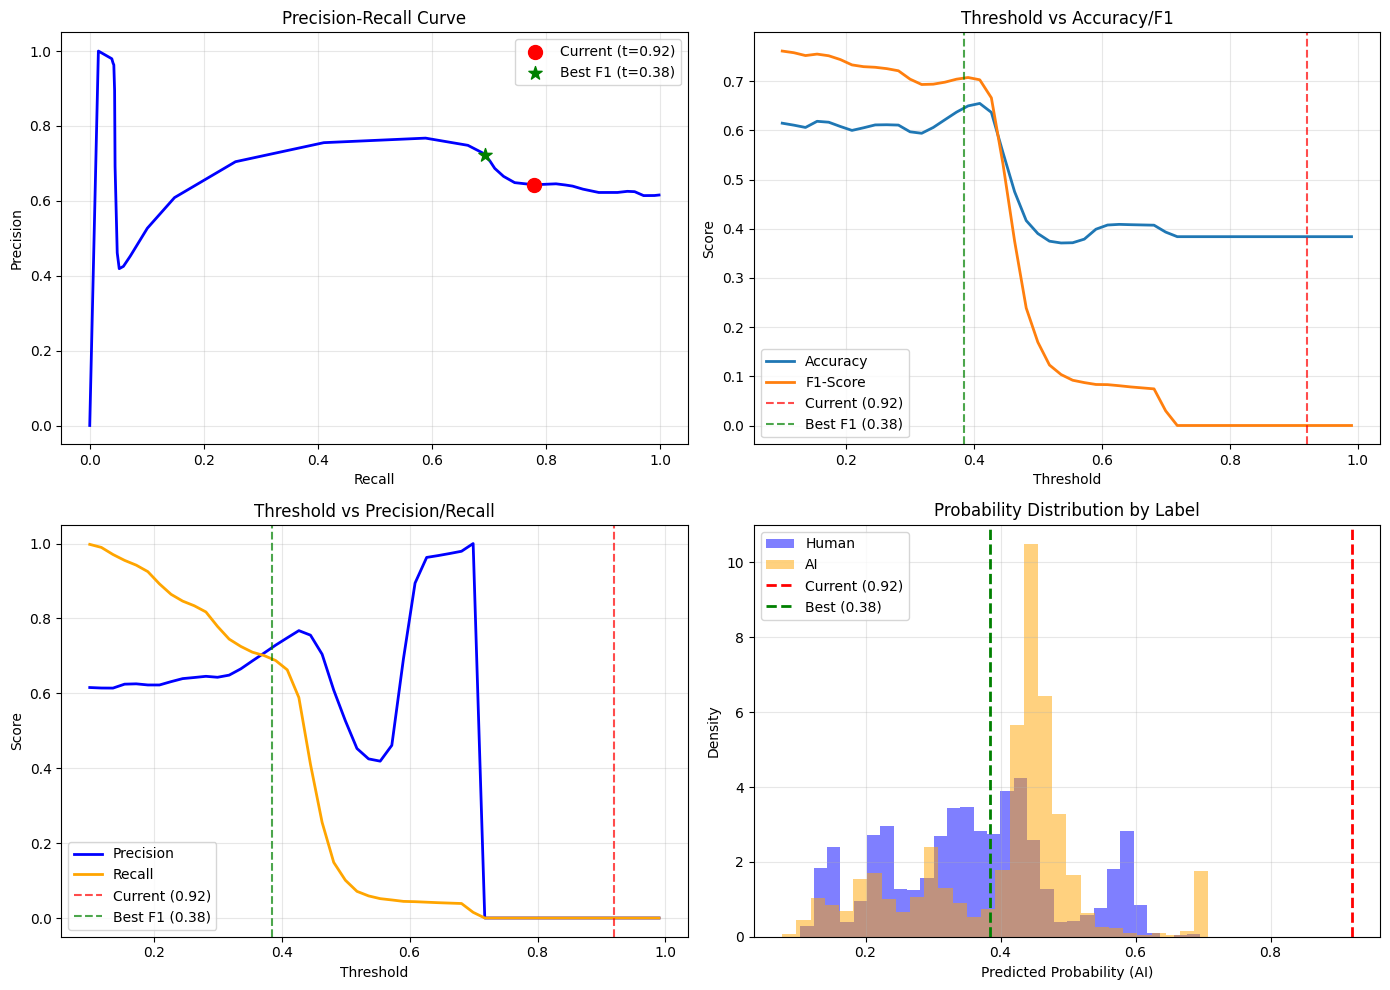

Threshold analysis complete. Plot saved to 'deberta_threshold_analysis.png'

4. Key Insights:
  • Human prob - Mean: 0.3593, Std: 0.1274
  • AI prob    - Mean: 0.4005, Std: 0.1238
  • Gap: 0.0412
  • Overlap: 23.8% of Human samples > AI median
  • Best threshold < 0.5 suggests model is biased toward predicting Human


In [ ]:
# debug
# threshold analysis
print("=== DeBERTa Baseline: Threshold Sensitivity Analysis ===")

print("\n1. Testing Different Thresholds:")
print(f"{'Threshold':<12} {'Accuracy':<10} {'Precision':<11} {'Recall':<9} {'F1-Score':<10} {'AUC':<10} {'Strategy':<20}")
print("-" * 95)

test_thresholds_deberta = [
    (0.3, "Low (0.3)"),
    (0.4, "Medium-Low (0.4)"),
    (0.5, "Default (0.5)"),
    (0.6, "Medium (0.6)"),
    (0.7, "Medium-High (0.7)"),
    (0.8, "High (0.8)"),
    (0.92, "Paper default (0.92)"),
    (np.median(deberta_probs), f"Median prob"),
    (np.mean(deberta_probs), f"Mean prob"),
]

best_acc_deberta = 0
best_acc_threshold_deberta = None
best_f1_deberta = 0
best_f1_threshold_deberta = None

threshold_results = []

for threshold, strategy in test_thresholds_deberta:
    preds = (np.array(deberta_probs) > threshold).astype(int)
    val_labels_array = np.array([d['label'] for d in val_data])

    acc = accuracy_score(val_labels_array, preds)
    prec = precision_score(val_labels_array, preds, zero_division=0)
    rec = recall_score(val_labels_array, preds, zero_division=0)
    f1 = f1_score(val_labels_array, preds, zero_division=0)
    auc = deberta_results['auc']

    threshold_results.append({
        'threshold': threshold,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'auc': auc
    })

    print(f"{threshold:<12.4f} {acc:<10.4f} {prec:<11.4f} {rec:<9.4f} {f1:<10.4f} {auc:<10.4f} {strategy:<20}")

    if acc > best_acc_deberta:
        best_acc_deberta = acc
        best_acc_threshold_deberta = threshold
    if f1 > best_f1_deberta:
        best_f1_deberta = f1
        best_f1_threshold_deberta = threshold

print("\n2. Best Results:")
print(f"  Best Accuracy:  {best_acc_deberta:.4f} at threshold={best_acc_threshold_deberta:.4f}")
print(f"  Best F1-Score:  {best_f1_deberta:.4f} at threshold={best_f1_threshold_deberta:.4f}")
print(f"  Current (0.92): Acc={deberta_results['accuracy']:.4f}, F1={deberta_results['f1']:.4f}")


print("\n3. Generating Threshold Analysis Plots...")
import matplotlib.pyplot as plt

# try finer range
threshold_range = np.linspace(0.1, 0.99, 50)
accuracies = []
precisions = []
recalls = []
f1s = []

for t in threshold_range:
    preds = (np.array(deberta_probs) > t).astype(int)
    accuracies.append(accuracy_score(val_labels_array, preds))
    precisions.append(precision_score(val_labels_array, preds, zero_division=0))
    recalls.append(recall_score(val_labels_array, preds, zero_division=0))
    f1s.append(f1_score(val_labels_array, preds, zero_division=0))


fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Precision vs Recall
axes[0, 0].plot(recalls, precisions, 'b-', linewidth=2)
axes[0, 0].scatter([deberta_results['recall']], [deberta_results['precision']],
                   c='red', s=100, zorder=5, label=f'Current (t=0.92)')
if best_f1_threshold_deberta != 0.92:
    best_result = [r for r in threshold_results if r['threshold'] == best_f1_threshold_deberta][0]
    axes[0, 0].scatter([best_result['recall']], [best_result['precision']],
                       c='green', s=100, marker='*', zorder=5, label=f'Best F1 (t={best_f1_threshold_deberta:.2f})')
axes[0, 0].set_xlabel('Recall')
axes[0, 0].set_ylabel('Precision')
axes[0, 0].set_title('Precision-Recall Curve')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# 2. Threshold vs Accuracy/F1
axes[0, 1].plot(threshold_range, accuracies, label='Accuracy', linewidth=2)
axes[0, 1].plot(threshold_range, f1s, label='F1-Score', linewidth=2)
axes[0, 1].axvline(0.92, color='red', linestyle='--', alpha=0.7, label='Current (0.92)')
if best_f1_threshold_deberta != 0.92:
    axes[0, 1].axvline(best_f1_threshold_deberta, color='green', linestyle='--', alpha=0.7, label=f'Best F1 ({best_f1_threshold_deberta:.2f})')
axes[0, 1].set_xlabel('Threshold')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_title('Threshold vs Accuracy/F1')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Threshold vs Precision/Recall
axes[1, 0].plot(threshold_range, precisions, label='Precision', linewidth=2, color='blue')
axes[1, 0].plot(threshold_range, recalls, label='Recall', linewidth=2, color='orange')
axes[1, 0].axvline(0.92, color='red', linestyle='--', alpha=0.7, label='Current (0.92)')
if best_f1_threshold_deberta != 0.92:
    axes[1, 0].axvline(best_f1_threshold_deberta, color='green', linestyle='--', alpha=0.7, label=f'Best F1 ({best_f1_threshold_deberta:.2f})')
axes[1, 0].set_xlabel('Threshold')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Threshold vs Precision/Recall')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. prob distribution by labels
human_probs_deberta = [deberta_probs[i] for i in range(len(deberta_probs)) if val_data[i]['label'] == 0]
ai_probs_deberta = [deberta_probs[i] for i in range(len(deberta_probs)) if val_data[i]['label'] == 1]

axes[1, 1].hist(human_probs_deberta, bins=30, alpha=0.5, label='Human', color='blue', density=True)
axes[1, 1].hist(ai_probs_deberta, bins=30, alpha=0.5, label='AI', color='orange', density=True)
axes[1, 1].axvline(0.92, color='red', linestyle='--', linewidth=2, label='Current (0.92)')
if best_f1_threshold_deberta != 0.92:
    axes[1, 1].axvline(best_f1_threshold_deberta, color='green', linestyle='--', linewidth=2, label=f'Best ({best_f1_threshold_deberta:.2f})')
axes[1, 1].set_xlabel('Predicted Probability (AI)')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Probability Distribution by Label')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('deberta_threshold_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("Threshold analysis complete. Plot saved to 'deberta_threshold_analysis.png'")

print("\n4. Key Insights:")
print(f"  • Human prob - Mean: {np.mean(human_probs_deberta):.4f}, Std: {np.std(human_probs_deberta):.4f}")
print(f"  • AI prob    - Mean: {np.mean(ai_probs_deberta):.4f}, Std: {np.std(ai_probs_deberta):.4f}")
print(f"  • Gap: {np.mean(ai_probs_deberta) - np.mean(human_probs_deberta):.4f}")

# distribution overlap
overlap_deberta = len([p for p in human_probs_deberta if p > np.median(ai_probs_deberta)])
print(f"  • Overlap: {overlap_deberta/len(human_probs_deberta)*100:.1f}% of Human samples > AI median")

if best_f1_threshold_deberta == 0.5:
    print(f"  • Threshold 0.5 gives best balance (standard logits interpretation)")
elif best_f1_threshold_deberta < 0.5:
    print(f"  • Best threshold < 0.5 suggests model is biased toward predicting Human")
else:
    print(f"  • Best threshold > 0.5 suggests model is biased toward predicting AI")

if deberta_results['f1'] == 0:
    print(f"  • Current threshold  is TOO HIGH - causing zero F1!")
    print(f"  • Recommendation: Use threshold={best_f1_threshold_deberta:.2f} for {best_f1_deberta:.1%} F1")

=== DeBERTa Baseline: Threshold Sensitivity Analysis (TEST) ===

1. Testing Different Thresholds:
Threshold    Accuracy   Precision   Recall    F1-Score   AUC        Strategy            
-----------------------------------------------------------------------------------------------
0.3000       0.5370     0.5311      0.9716    0.6868     0.5934     Low (0.3)           
0.4000       0.5479     0.5447      0.8206    0.6548     0.5934     Medium-Low (0.4)    
0.5000       0.4985     0.5269      0.3942    0.4510     0.5934     Default (0.5)       
0.6000       0.6101     0.8430      0.3118    0.4553     0.5934     Medium (0.6)        
0.7000       0.4965     0.9831      0.0370    0.0714     0.5934     Medium-High (0.7)   
0.8000       0.4775     0.0000      0.0000    0.0000     0.5934     High (0.8)          
0.9200       0.4775     0.0000      0.0000    0.0000     0.5934     Paper default (0.92)
0.4639       0.5192     0.5417      0.5184    0.5298     0.5934     Median prob         
0.488

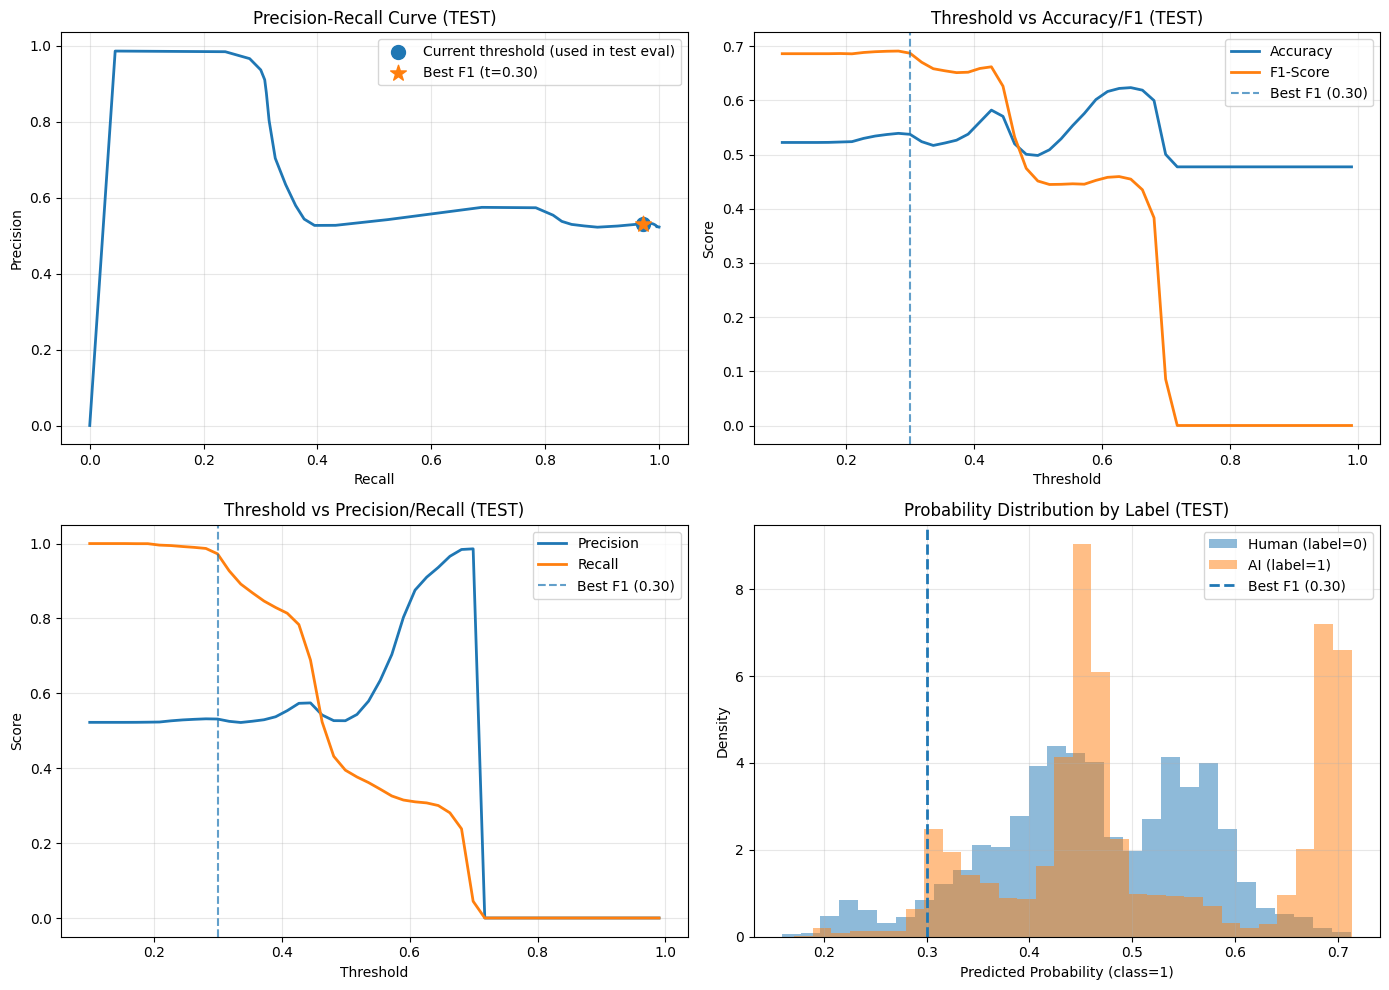

Threshold analysis complete. Plot saved to 'deberta_threshold_analysis_test.png'

4. Key Insights (TEST):
  • Human prob - Mean: 0.4627, Std: 0.1013
  • AI prob    - Mean: 0.5113, Std: 0.1331
  • Gap (AI - Human): 0.0486
  • Overlap: 46.9% of Human samples > AI median
  • Best threshold < 0.5 suggests class-1 probability tends to be high (or label direction may be flipped).


In [ ]:
# debug
# threshold analysis (TEST SET)
print("=== DeBERTa Baseline: Threshold Sensitivity Analysis (TEST) ===")

test_labels_array = np.array([d["label"] for d in test_data])
deberta_test_probs_array = np.array(deberta_test_probs)

print("\n1. Testing Different Thresholds:")
print(f"{'Threshold':<12} {'Accuracy':<10} {'Precision':<11} {'Recall':<9} {'F1-Score':<10} {'AUC':<10} {'Strategy':<20}")
print("-" * 95)

test_thresholds_deberta = [
    (0.3, "Low (0.3)"),
    (0.4, "Medium-Low (0.4)"),
    (0.5, "Default (0.5)"),
    (0.6, "Medium (0.6)"),
    (0.7, "Medium-High (0.7)"),
    (0.8, "High (0.8)"),
    (0.92, "Paper default (0.92)"),
    (float(np.median(deberta_test_probs_array)), "Median prob"),
    (float(np.mean(deberta_test_probs_array)), "Mean prob"),
]

best_acc_deberta = -1
best_acc_threshold_deberta = None
best_f1_deberta = -1
best_f1_threshold_deberta = None

threshold_results = []

# AUC is threshold-free; keep it as the global one (or recompute once on test)
auc = deberta_test_results["auc"]

for threshold, strategy in test_thresholds_deberta:
    preds = (deberta_test_probs_array > threshold).astype(int)

    acc = accuracy_score(test_labels_array, preds)
    prec = precision_score(test_labels_array, preds, zero_division=0)
    rec = recall_score(test_labels_array, preds, zero_division=0)
    f1 = f1_score(test_labels_array, preds, zero_division=0)

    threshold_results.append({
        "threshold": float(threshold),
        "accuracy": float(acc),
        "precision": float(prec),
        "recall": float(rec),
        "f1": float(f1),
        "auc": float(auc) if auc is not None else None
    })

    print(f"{threshold:<12.4f} {acc:<10.4f} {prec:<11.4f} {rec:<9.4f} {f1:<10.4f} {auc:<10.4f} {strategy:<20}")

    if acc > best_acc_deberta:
        best_acc_deberta = acc
        best_acc_threshold_deberta = threshold
    if f1 > best_f1_deberta:
        best_f1_deberta = f1
        best_f1_threshold_deberta = threshold

print("\n2. Best Results (TEST):")
print(f"  Best Accuracy:  {best_acc_deberta:.4f} at threshold={best_acc_threshold_deberta:.4f}")
print(f"  Best F1-Score:  {best_f1_deberta:.4f} at threshold={best_f1_threshold_deberta:.4f}")

print(f"  Current (the threshold you used to compute deberta_test_results): "
      f"Acc={deberta_test_results['accuracy']:.4f}, F1={deberta_test_results['f1']:.4f}, AUC={deberta_test_results['auc']:.4f}")


print("\n3. Generating Threshold Analysis Plots (TEST)...")
import matplotlib.pyplot as plt

threshold_range = np.linspace(0.1, 0.99, 50)
accuracies, precisions, recalls, f1s = [], [], [], []

for t in threshold_range:
    preds = (deberta_test_probs_array > t).astype(int)
    accuracies.append(accuracy_score(test_labels_array, preds))
    precisions.append(precision_score(test_labels_array, preds, zero_division=0))
    recalls.append(recall_score(test_labels_array, preds, zero_division=0))
    f1s.append(f1_score(test_labels_array, preds, zero_division=0))

# Pick best F1 point info for PR scatter
best_result = [r for r in threshold_results if r["threshold"] == float(best_f1_threshold_deberta)][0]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1) Precision-Recall curve (sweeping threshold)
axes[0, 0].plot(recalls, precisions, linewidth=2)
axes[0, 0].scatter([deberta_test_results["recall"]], [deberta_test_results["precision"]],
                   s=100, zorder=5, label='Current threshold (used in test eval)')
axes[0, 0].scatter([best_result["recall"]], [best_result["precision"]],
                   s=140, marker='*', zorder=6, label=f'Best F1 (t={best_f1_threshold_deberta:.2f})')
axes[0, 0].set_xlabel("Recall")
axes[0, 0].set_ylabel("Precision")
axes[0, 0].set_title("Precision-Recall Curve (TEST)")
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# 2) Threshold vs Accuracy/F1
axes[0, 1].plot(threshold_range, accuracies, label="Accuracy", linewidth=2)
axes[0, 1].plot(threshold_range, f1s, label="F1-Score", linewidth=2)
axes[0, 1].axvline(best_f1_threshold_deberta, linestyle="--", alpha=0.7, label=f"Best F1 ({best_f1_threshold_deberta:.2f})")
axes[0, 1].set_xlabel("Threshold")
axes[0, 1].set_ylabel("Score")
axes[0, 1].set_title("Threshold vs Accuracy/F1 (TEST)")
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# 3) Threshold vs Precision/Recall
axes[1, 0].plot(threshold_range, precisions, label="Precision", linewidth=2)
axes[1, 0].plot(threshold_range, recalls, label="Recall", linewidth=2)
axes[1, 0].axvline(best_f1_threshold_deberta, linestyle="--", alpha=0.7, label=f"Best F1 ({best_f1_threshold_deberta:.2f})")
axes[1, 0].set_xlabel("Threshold")
axes[1, 0].set_ylabel("Score")
axes[1, 0].set_title("Threshold vs Precision/Recall (TEST)")
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

# 4) Probability distribution by true labels (TEST)
human_probs = deberta_test_probs_array[test_labels_array == 0]
ai_probs = deberta_test_probs_array[test_labels_array == 1]

axes[1, 1].hist(human_probs, bins=30, alpha=0.5, label="Human (label=0)", density=True)
axes[1, 1].hist(ai_probs, bins=30, alpha=0.5, label="AI (label=1)", density=True)
axes[1, 1].axvline(best_f1_threshold_deberta, linestyle="--", linewidth=2, label=f"Best F1 ({best_f1_threshold_deberta:.2f})")
axes[1, 1].set_xlabel("Predicted Probability (class=1)")
axes[1, 1].set_ylabel("Density")
axes[1, 1].set_title("Probability Distribution by Label (TEST)")
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

plt.tight_layout()
plt.savefig("deberta_threshold_analysis_test.png", dpi=150, bbox_inches="tight")
plt.show()

print("Threshold analysis complete. Plot saved to 'deberta_threshold_analysis_test.png'")

print("\n4. Key Insights (TEST):")
print(f"  • Human prob - Mean: {float(np.mean(human_probs)):.4f}, Std: {float(np.std(human_probs)):.4f}")
print(f"  • AI prob    - Mean: {float(np.mean(ai_probs)):.4f}, Std: {float(np.std(ai_probs)):.4f}")
print(f"  • Gap (AI - Human): {float(np.mean(ai_probs) - np.mean(human_probs)):.4f}")

overlap = np.mean(human_probs > np.median(ai_probs)) if len(ai_probs) else float("nan")
print(f"  • Overlap: {overlap*100:.1f}% of Human samples > AI median")

if best_f1_threshold_deberta < 0.5:
    print("  • Best threshold < 0.5 suggests class-1 probability tends to be high (or label direction may be flipped).")
elif best_f1_threshold_deberta > 0.5:
    print("  • Best threshold > 0.5 suggests model needs a high cutoff to predict class 1.")
else:
    print("  • Best threshold = 0.5 (standard interpretation).")

# 5. Train


In [ ]:
# prepare data
train_dataset = MGTDatasetWithPerplexity(train_data, train_scores_normalized, tokenizer)
val_dataset = MGTDatasetWithPerplexity(val_data, val_scores_normalized, tokenizer)
test_dataset = MGTDatasetWithPerplexity(test_data, test_scores_normalized, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"DataLoaders created")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")

DataLoaders created
  Train batches: 625
  Val batches: 188


In [ ]:
from transformers.optimization import get_linear_schedule_with_warmup
from torch.optim import AdamW # Use torch.optim.AdamW

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
new_model.to(device)

print("=== Training Classifier Head Only ===")

for param in new_model.deberta.parameters():
    param.requires_grad = False
for param in new_model.pooler.parameters():
    param.requires_grad = False

optimizer = AdamW(filter(lambda p: p.requires_grad, new_model.parameters()), lr=3e-4)
num_epochs_stage1 = 1
total_steps = len(train_loader) * num_epochs_stage1
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=50, num_training_steps=total_steps)

print(f"Trainable parameters: {sum(p.numel() for p in new_model.parameters() if p.requires_grad):,}")
print(f"Training for {num_epochs_stage1} epoch(s), {total_steps} steps")

=== Stage 1: Training Classifier Head Only ===
Trainable parameters: 526,082
Training for 1 epoch(s), 625 steps


In [ ]:
# Stage 1 训练循环
from tqdm.auto import tqdm

new_model.train()
best_val_f1 = 0

for epoch in range(num_epochs_stage1):
    print(f"\nEpoch {epoch+1}/{num_epochs_stage1}")
    epoch_loss = 0

    progress_bar = tqdm(train_loader, desc=f"Training")
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        perplexity_feature = batch['perplexity_feature'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = new_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            perplexity_feature=perplexity_feature,
            labels=labels
        )

        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_loss = epoch_loss / len(train_loader)
    print(f"Average Loss: {avg_loss:.4f}")

    # 验证
    new_model.eval()
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            perplexity_feature = batch['perplexity_feature'].to(device)
            labels = batch['labels'].to(device)

            outputs = new_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                perplexity_feature=perplexity_feature
            )

            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            val_preds.extend(preds)
            val_labels.extend(labels.cpu().numpy())

    val_f1 = f1_score(val_labels, val_preds)
    val_acc = accuracy_score(val_labels, val_preds)
    print(f"Validation - Accuracy: {val_acc:.4f}, F1: {val_f1:.4f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(new_model.state_dict(), 'best_model_stage1.pt')
        print(f"✓ Best model saved (F1={val_f1:.4f})")

    new_model.train()

print(f"\nStage 1 Complete. Best Val F1: {best_val_f1:.4f}")


Epoch 1/1


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Average Loss: 0.1076


Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Validation - Accuracy: 0.9552, F1: 0.9643
✓ Best model saved (F1=0.9643)

Stage 1 Complete. Best Val F1: 0.9643


# 6. Further evaluation

In [ ]:
!pip install gdown

In [ ]:
# download saved model trained before
!gdown --id 1ou5s2dG-pmPqDgzMt1IIuDbL1ZXnWcCT

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1ou5s2dG-pmPqDgzMt1IIuDbL1ZXnWcCT
From (redirected): https://drive.google.com/uc?id=1ou5s2dG-pmPqDgzMt1IIuDbL1ZXnWcCT&confirm=t&uuid=52f27d69-5a0e-44a3-b5b5-e7a6d4442193
To: /content/best_model_stage1.pt
100% 740M/740M [00:18<00:00, 40.5MB/s]


In [ ]:
# load model for further evaluation
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
new_model.load_state_dict(torch.load('/content/best_model_stage1.pt'))
new_model.eval()

def evaluate_model_with_perplexity(model, data_list, perplexity_scores, tokenizer, batch_size=32):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []
    all_sources = []
    all_sub_sources = []
    all_model = []

    dataset = MGTDatasetWithPerplexity(data_list, perplexity_scores, tokenizer)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            perplexity_feature = batch['perplexity_feature'].to(device)
            labels = batch['labels']

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                perplexity_feature=perplexity_feature
            )

            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
            preds = torch.argmax(logits, dim=1).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
            all_probs.extend(probs)
            all_sources.extend(batch['source'])
            all_sub_sources.extend(batch['sub_source'])
            all_model.extend(batch['model'])


    # Overall metrics
    results = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds, zero_division=0),
        'recall': recall_score(all_labels, all_preds, zero_division=0),
        'f1': f1_score(all_labels, all_preds, zero_division=0),
        'auc': roc_auc_score(all_labels, all_probs) if len(set(all_labels)) > 1 else 0.0
    }

    return results, all_preds, all_probs, all_sources, all_sub_sources, all_model

## Evaluate on validation set

### key metrics

In [ ]:
final_results, final_preds, final_probs, final_sources, final_sub_sources, final_models = evaluate_model_with_perplexity(
    new_model,
    val_data,
    val_scores_normalized,
    tokenizer
)

print("\n=== Overall Results ===")
print(f"Accuracy:  {final_results['accuracy']:.4f}")
print(f"Precision: {final_results['precision']:.4f}")
print(f"Recall:    {final_results['recall']:.4f}")
print(f"F1-Score:  {final_results['f1']:.4f}")
print(f"AUC:       {final_results['auc']:.4f}")

Evaluating: 100%|██████████| 188/188 [04:56<00:00,  1.58s/it]


=== Overall Results ===
Accuracy:  0.9552
Precision: 0.9456
Recall:    0.9838
F1-Score:  0.9643
AUC:       0.9940


### by sub-source

In [ ]:
final_labels = [d["label"] for d in val_data]

hybrid_sub_df = evaluate_by_group(
    data_list=val_data,
    labels=final_labels,
    preds=final_preds,
    probs=final_probs,
    group_key="sub_source",
    model_name="Intergrated model"
)
display(hybrid_sub_df)

,model,sub_source,count,accuracy,precision,recall,f1,auc
0,Intergrated model,wikihow,565,0.998230,1.000000,0.997101,0.998549,0.999987
1,Intergrated model,arxiv,525,0.925714,0.884498,0.996575,0.937198,0.995517
2,Intergrated model,reddit,483,0.971014,0.960656,0.993220,0.976667,0.998972
3,Intergrated model,wikipedia,473,0.974630,0.959559,0.996183,0.977528,0.999692
4,Intergrated model,reddit_eli5,448,1.000000,1.000000,1.000000,1.000000,1.000000
5,Intergrated model,outfox,410,0.948780,0.948780,1.000000,0.973717,0.902436
6,Intergrated model,yelp,407,0.926290,0.916129,0.893082,0.904459,0.982958
7,Intergrated model,eli5,352,0.923295,0.914894,0.968468,0.940919,0.987006
8,Intergrated model,xsum,305,0.973770,0.967611,1.000000,0.983539,0.996830
9,Intergrated model,squad,300,0.873333,0.808642,0.949275,0.873333,0.975711


In [ ]:
with open("hybridmodel_by_domain.json", "w") as f:
    json.dump(hybrid_sub_df.to_dict("records"), f, indent=2)

### by source

In [ ]:
final_labels = [d["label"] for d in val_data]
hybrid_souce_df = evaluate_by_group(
    data_list=val_data,
    labels=final_labels,
    preds=final_preds,
    probs=final_probs,
    group_key="source",
    model_name="Intergrated model"
)
display(hybrid_souce_df)

,model,source,count,accuracy,precision,recall,f1,auc
0,Intergrated model,mage,2807,0.937656,0.935170,0.969205,0.951883,0.988027
1,Intergrated model,m4gt,2624,0.966082,0.953668,0.997116,0.974908,0.996296
2,Intergrated model,hc3,567,0.991182,0.972222,1.000000,0.985915,0.999971


### by model

In [ ]:
hybrid_model_df = evaluate_by_group(
    data_list=val_data,
    labels=final_labels,
    preds=final_preds,
    probs=final_probs,
    group_key="model",
    model_name="Intergrated model"
)
display(hybrid_model_df)

,model,count,accuracy,precision,recall,f1,auc
0,human,2303,0.909249,0.0,0.000000,0.000000,None
1,gpt-3.5-turbo,410,0.997561,1.0,0.997561,0.998779,None
2,bloomz,208,0.995192,1.0,0.995192,0.997590,None
3,davinci,185,0.994595,1.0,0.994595,0.997290,None
4,gpt-35,175,1.000000,1.0,1.000000,1.000000,None
5,text-davinci-003,173,0.988439,1.0,0.988439,0.994186,None
6,cohere,172,1.000000,1.0,1.000000,1.000000,None
7,mixtral-8x7b,149,1.000000,1.0,1.000000,1.000000,None
8,text-davinci-002,140,0.985714,1.0,0.985714,0.992806,None
9,llama3-8b,134,1.000000,1.0,1.000000,1.000000,None


## Evaluate on test set

### key metrics

In [ ]:
final_results_test, final_preds_test, final_probs_test, final_sources_test, final_sub_sources_test, final_models_test = evaluate_model_with_perplexity(
    new_model,
    test_data,
    test_scores_normalized,
    tokenizer
)

print("\n=== Overall Results ===")
print(f"Accuracy:  {final_results_test['accuracy']:.4f}")
print(f"Precision: {final_results_test['precision']:.4f}")
print(f"Recall:    {final_results_test['recall']:.4f}")
print(f"F1-Score:  {final_results_test['f1']:.4f}")
print(f"AUC:       {final_results_test['auc']:.4f}")

Evaluating: 100%|██████████| 188/188 [05:02<00:00,  1.61s/it]


=== Overall Results ===
Accuracy:  0.7702
Precision: 0.7248
Recall:    0.9030
F1-Score:  0.8042
AUC:       0.9018


### by sub-source

In [ ]:
final_test_labels = [d["label"] for d in test_data]
hybrid_sub_test_df = evaluate_by_group(
    data_list=test_data,
    labels=final_test_labels,
    preds=final_preds_test,
    probs=final_probs_test,
    group_key="sub_source",
    model_name="Intergrated model"
)
display(hybrid_sub_test_df)

,model,sub_source,count,accuracy,precision,recall,f1,auc
0,Intergrated model,ielts,1682,0.727705,0.657186,1.000000,0.793135,0.978645
1,Intergrated model,nodomain,979,0.910112,0.859425,1.000000,0.924399,0.998487
2,Intergrated model,Academic peer review,868,0.846774,0.766257,1.000000,0.867662,0.999522
3,Intergrated model,GPT3.5_Refine,434,0.921659,0.404255,0.760000,0.527778,0.958435
4,Intergrated model,GPT3.5_QA,408,0.909314,0.421875,1.000000,0.593407,0.990085
5,Intergrated model,GPT3.5_Summary,240,0.070833,0.059633,0.419355,0.104418,0.133971
6,Intergrated model,IELTS Essay,205,0.604878,0.444444,0.984615,0.612440,0.952747
7,Intergrated model,IELTS,116,1.000000,1.000000,1.000000,1.000000,NaN
8,Intergrated model,game_review,41,0.707317,1.000000,0.707317,0.828571,NaN
9,Intergrated model,TruthfulQA_LLMs,38,0.473684,0.472222,0.944444,0.629630,0.136111


In [ ]:
with open("hybridmodel_by_domain_test.json", "w") as f:
    json.dump(hybrid_sub_test_df.to_dict("records"), f, indent=2)

### by source

In [ ]:
hybrid_souce_test_df = evaluate_by_group(
    data_list=test_data,
    labels=final_test_labels,
    preds=final_preds_test,
    probs=final_probs_test,
    group_key="source",
    model_name="Intergrated model"
)
display(hybrid_souce_test_df)

,model,source,count,accuracy,precision,recall,f1,auc
0,Intergrated model,CUDRT,1864,0.719957,0.694224,0.708671,0.701373,0.815713
1,Intergrated model,ieltsduck,1798,0.745273,0.684573,1.000000,0.812756,0.977930
2,Intergrated model,peersum,979,0.910112,0.859425,1.000000,0.924399,0.998487
3,Intergrated model,NLPeer-F1000,795,0.857862,0.781431,1.000000,0.877307,0.999544
4,Intergrated model,Mixset,282,0.659574,0.803493,0.782979,0.793103,0.120552
5,Intergrated model,LLM-DetectAIve-IELTS,205,0.604878,0.444444,0.984615,0.612440,0.952747
6,Intergrated model,NLPeer-ARR22,59,0.711864,0.595238,1.000000,0.746269,0.998824
7,Intergrated model,NLPeer-COLING20,14,0.785714,0.700000,1.000000,0.823529,1.000000


### by model

In [ ]:
hybrid_model_test_df = evaluate_by_group(
    data_list=test_data,
    labels=final_test_labels,
    preds=final_preds_test,
    probs=final_probs_test,
    group_key="model",
    model_name="Intergrated model"
)
display(hybrid_model_test_df)

,model,count,accuracy,precision,recall,f1,auc
0,human,2816,0.634588,0.000000,0.000000,0.000000,NaN
1,gpt-4o-mini-2024-07-18,1135,1.000000,1.000000,1.000000,1.000000,NaN
2,gpt-4o,436,1.000000,1.000000,1.000000,1.000000,NaN
3,gpt-4o-2024-08-06,281,1.000000,1.000000,1.000000,1.000000,NaN
4,nodomain,196,0.790816,1.000000,0.790816,0.883191,NaN
5,GPT3.5,174,0.781609,1.000000,0.781609,0.877419,NaN
6,ChatGLM,165,0.581818,0.887850,0.625000,0.733591,0.092611
7,Baichuan,146,0.554795,1.000000,0.554795,0.713656,NaN
8,Qwen,141,0.808511,1.000000,0.808511,0.894118,NaN
9,Llama2,136,0.720588,1.000000,0.720588,0.837607,NaN


## Overall Comparison

### validation set

/tmp/ipython-input-3916646031.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat(dfs, ignore_index=True)
/tmp/ipython-input-3916646031.py:41: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide[m] = df_all.pivot_table(index=group_col, columns="model_name", values=m, aggfunc="first").sort_index()
/tmp/ipython-input-3916646031.py:41: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide[m] = df_all.pivot

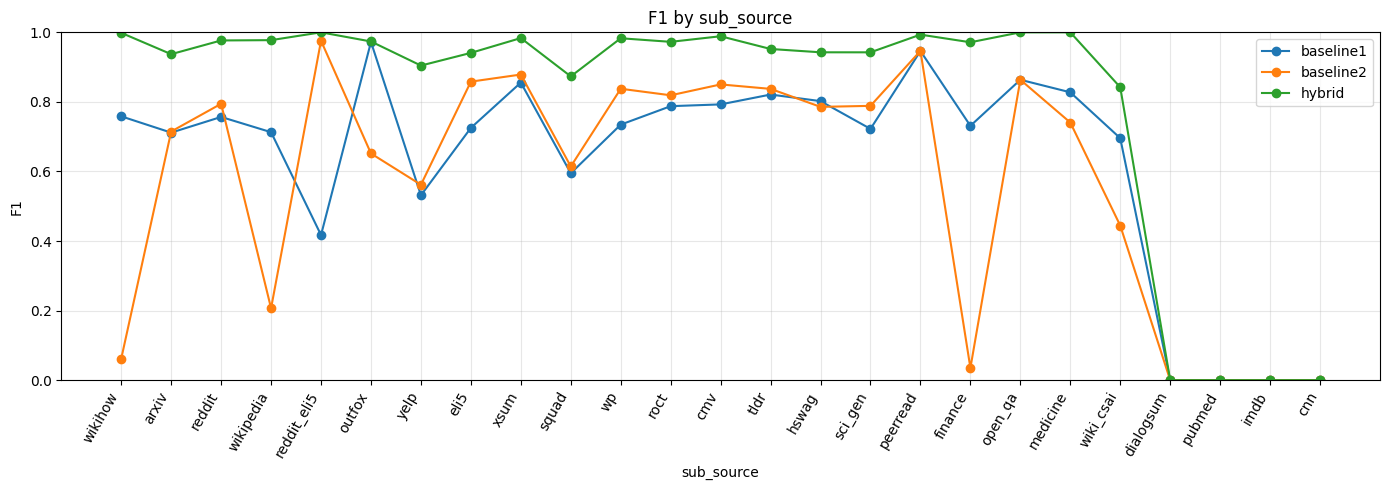

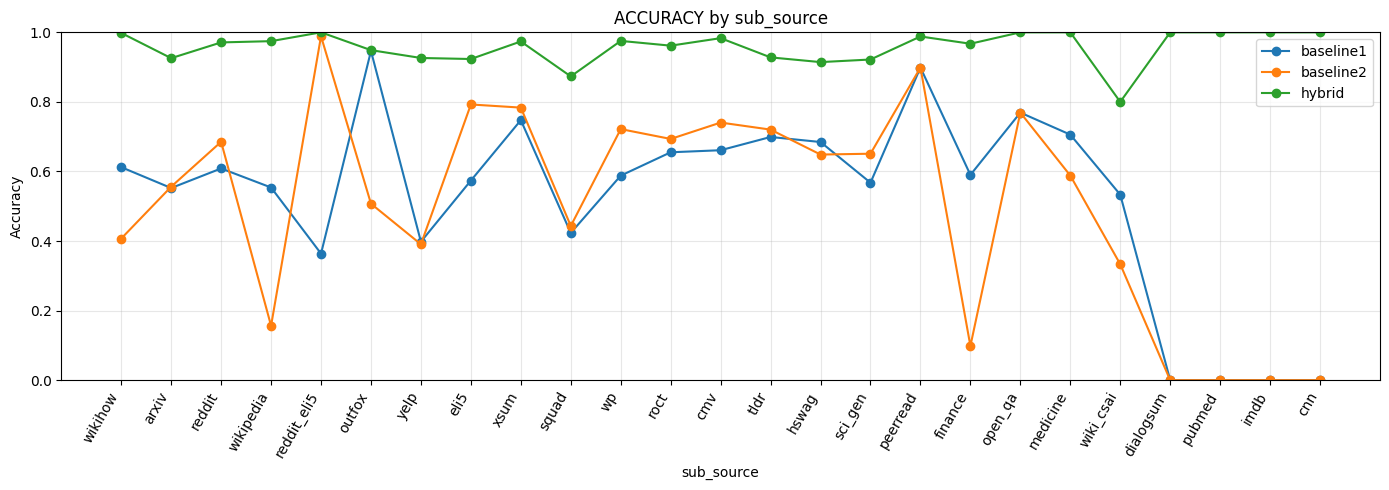

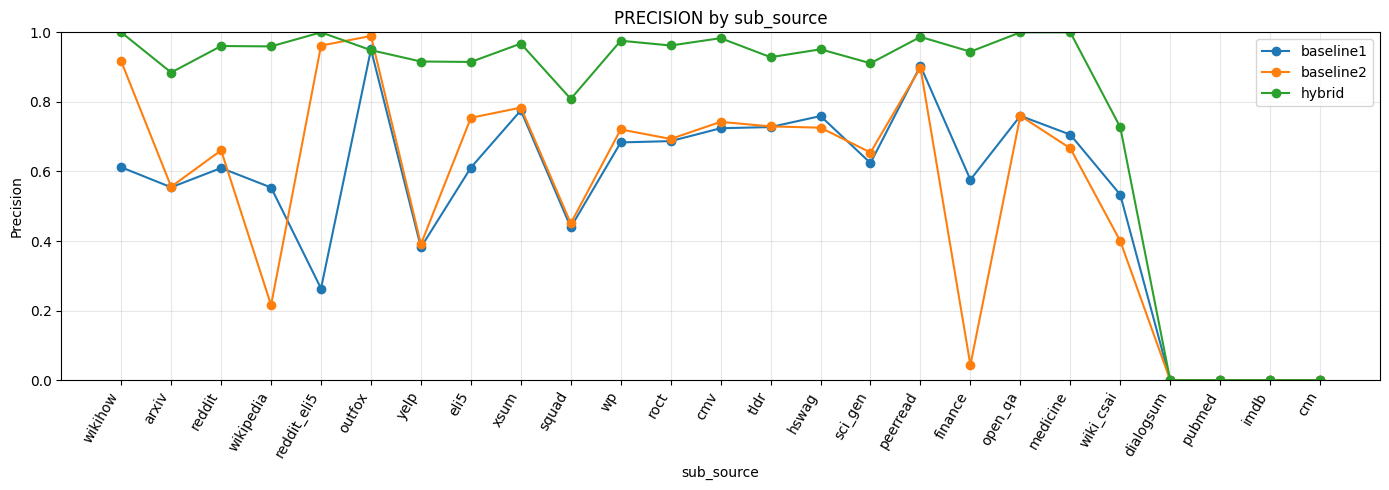

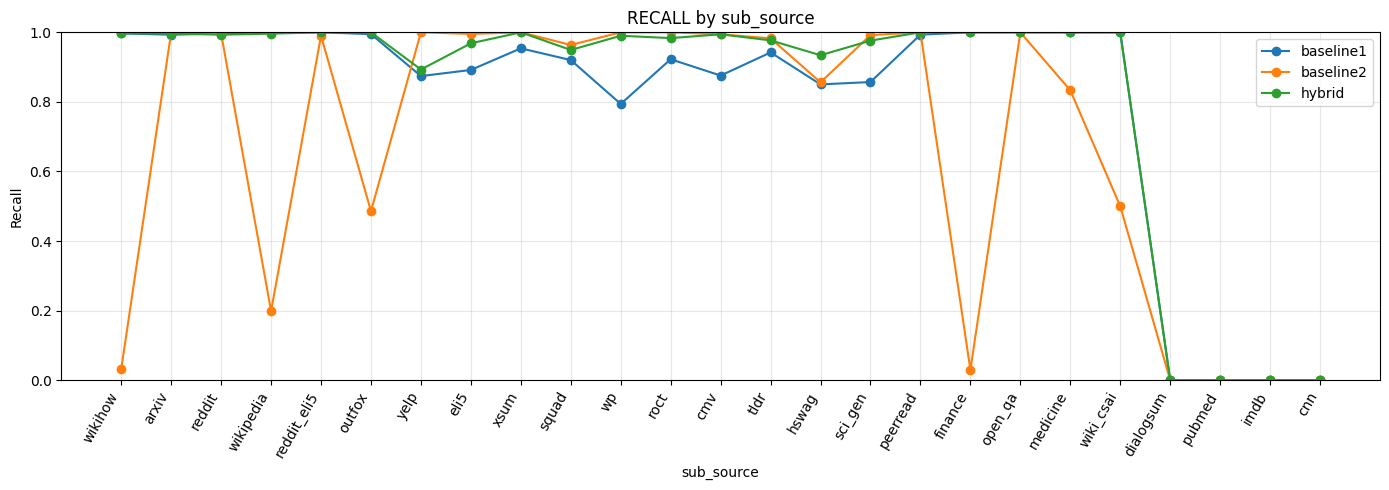

In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- 1) load ----------
paths = {
    "baseline1": "/content/baseline1_by_sub_source.json",
    "baseline2": "/content/baseline2_by_sub_source.json",
    "hybrid":    "/content/hybridmodel_by_domain.json",
}

dfs = []
for name, p in paths.items():
    with open(p, "r") as f:
        rows = json.load(f)
    df = pd.DataFrame(rows)
    df["model_name"] = name
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

group_col = "sub_source"

# ---------- 2) choose x-axis order ----------
order = (df_all[df_all["model_name"]=="baseline2"]
         .sort_values("count", ascending=False)[group_col]
         .tolist())

all_groups = df_all[group_col].unique().tolist()
for g in all_groups:
    if g not in order:
        order.append(g)

df_all[group_col] = pd.Categorical(df_all[group_col], categories=order, ordered=True)

# ---------- 3) pivot to wide table for plotting ----------
metrics = ["f1", "accuracy", "precision", "recall"]
wide = {}
for m in metrics:
    wide[m] = df_all.pivot_table(index=group_col, columns="model_name", values=m, aggfunc="first").sort_index()

# ---------- 4) plot ----------
def plot_metric(metric_name, ylabel=None, save_path=None):
    w = wide[metric_name].copy()
    plt.figure(figsize=(14, 5))
    for model_name in ["baseline1", "baseline2", "hybrid"]:
        if model_name in w.columns:
            plt.plot(w.index.astype(str), w[model_name], marker="o", label=model_name)

    plt.xticks(rotation=60, ha="right")
    plt.ylim(0, 1.0)
    plt.grid(True, alpha=0.3)
    plt.xlabel(group_col)
    plt.ylabel(ylabel or metric_name)
    plt.title(f"{metric_name.upper()} by {group_col}")
    plt.legend()
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=200)
    plt.show()

plot_metric("f1",        "F1",        "/content/compare_f1.png")
plot_metric("accuracy",  "Accuracy",  "/content/compare_accuracy.png")
plot_metric("precision", "Precision", "/content/compare_precision.png")
plot_metric("recall",    "Recall",    "/content/compare_recall.png")

### test set

/tmp/ipython-input-3075735833.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat(dfs, ignore_index=True)
/tmp/ipython-input-3075735833.py:41: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide[m] = df_all.pivot_table(index=group_col, columns="model_name", values=m, aggfunc="first").sort_index()
/tmp/ipython-input-3075735833.py:41: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide[m] = df_all.pivot

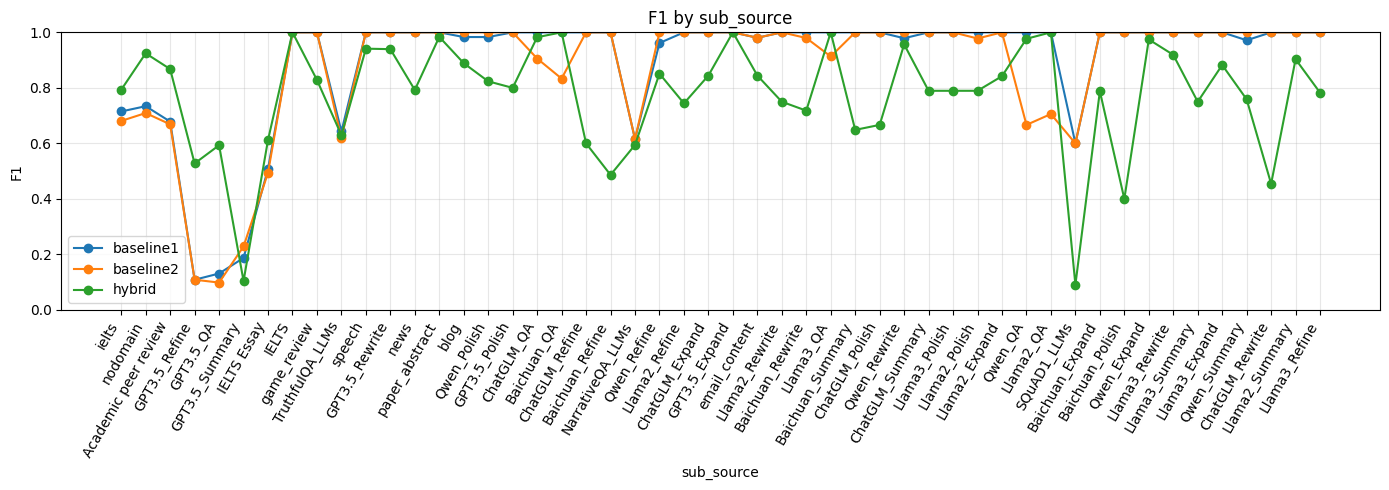

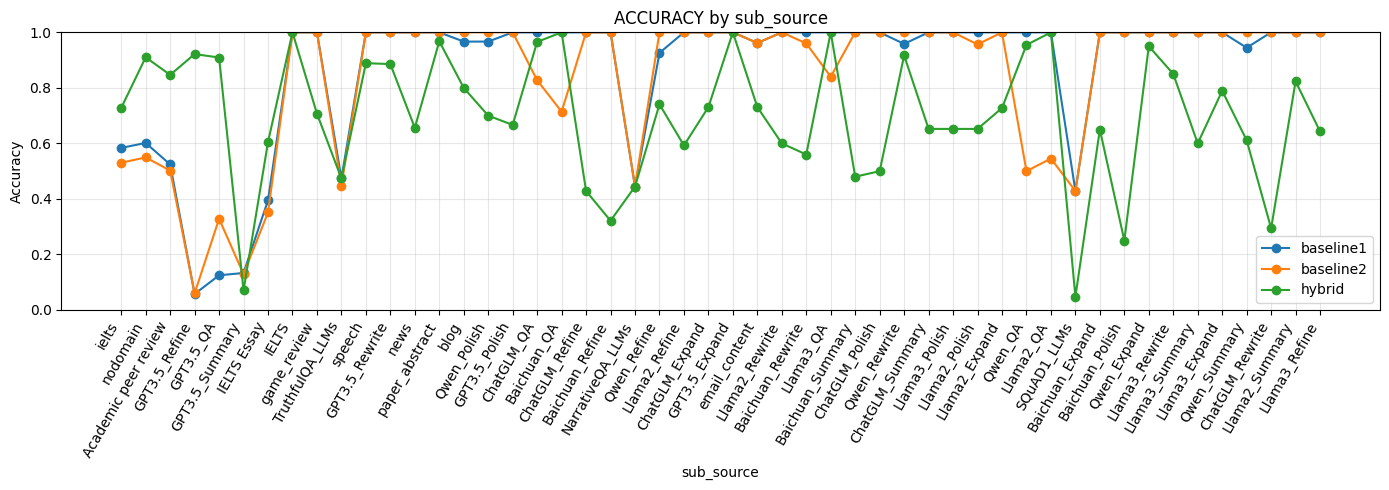

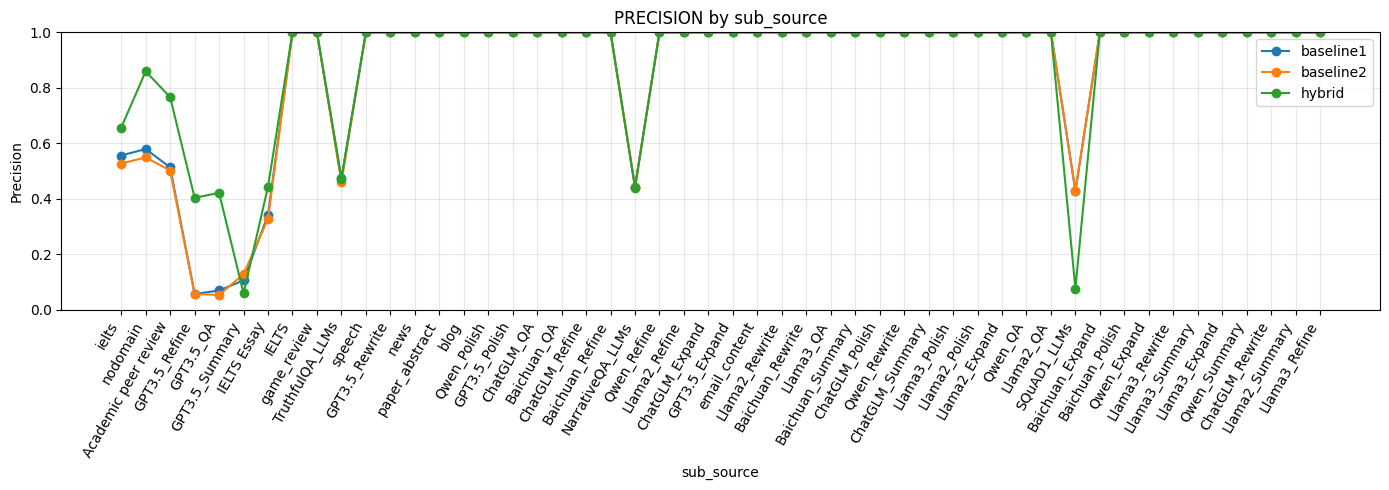

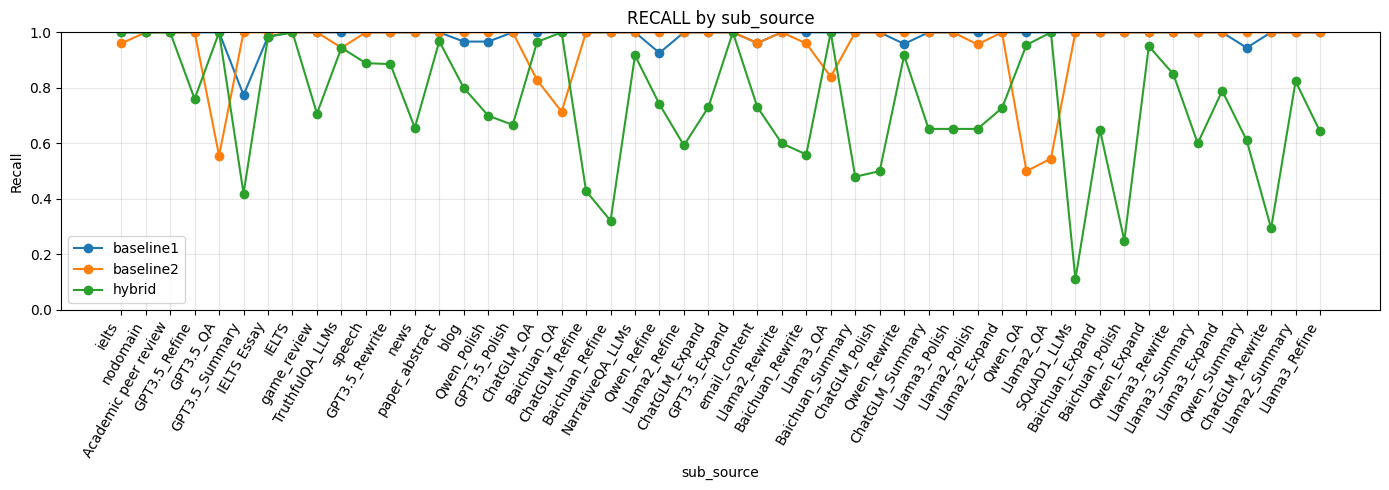

In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- 1) load ----------
paths = {
    "baseline1": "/content/baseline1_by_sub_source_test.json",
    "baseline2": "/content/baseline2_by_sub_source_test.json",
    "hybrid":    "/content/hybridmodel_by_domain_test.json",
}

dfs = []
for name, p in paths.items():
    with open(p, "r") as f:
        rows = json.load(f)
    df = pd.DataFrame(rows)
    df["model_name"] = name
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

group_col = "sub_source"

# ---------- 2) choose x-axis order ----------
order = (df_all[df_all["model_name"]=="baseline2"]
         .sort_values("count", ascending=False)[group_col]
         .tolist())

all_groups = df_all[group_col].unique().tolist()
for g in all_groups:
    if g not in order:
        order.append(g)

df_all[group_col] = pd.Categorical(df_all[group_col], categories=order, ordered=True)

# ---------- 3) pivot to wide table for plotting ----------
metrics = ["f1", "accuracy", "precision", "recall"]
wide = {}
for m in metrics:
    wide[m] = df_all.pivot_table(index=group_col, columns="model_name", values=m, aggfunc="first").sort_index()

# ---------- 4) plot ----------
def plot_metric(metric_name, ylabel=None, save_path=None):
    w = wide[metric_name].copy()
    plt.figure(figsize=(14, 5))
    for model_name in ["baseline1", "baseline2", "hybrid"]:
        if model_name in w.columns:
            plt.plot(w.index.astype(str), w[model_name], marker="o", label=model_name)

    plt.xticks(rotation=60, ha="right")
    plt.ylim(0, 1.0)
    plt.grid(True, alpha=0.3)
    plt.xlabel(group_col)
    plt.ylabel(ylabel or metric_name)
    plt.title(f"{metric_name.upper()} by {group_col}")
    plt.legend()
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=200)
    plt.show()

plot_metric("f1",        "F1",        "/content/compare_f1_test.png")
plot_metric("accuracy",  "Accuracy",  "/content/compare_accuracy_test.png")
plot_metric("precision", "Precision", "/content/compare_precision_test.png")
plot_metric("recall",    "Recall",    "/content/compare_recall_test.png")